In [ ]:
if_save = None
num_sims = None
num_time_steps = None
num_agents = None
num_seconds = None
step_std = None
inner_circle_radius = None
sample_rate = None
folder = None

In [90]:
# common libs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# audio
import librosa
import soundfile
from IPython.display import Audio
from audiomentations import *

In [ ]:
if_save = False
num_sims = 2
num_time_steps = 10
num_agents = 20
num_seconds = 3
step_std = 0.1
inner_circle_radius = 0.25
sample_rate = 22050
folder = 'data/birdclef-2022/train_audio'
species = os.listdir(folder)
audio_dict = dict()
for _ in species:
    subfolder = os.path.join(folder, _)
    audio_files = [f for f in os.listdir(subfolder) if f.endswith('.ogg')]
    audio_dict[_] = audio_files
species_labels = {sp: idx for idx, sp in enumerate(species, start=1)}
os.listdir(folder)[:5]

['afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik']

## Define the Bird class

In [36]:
class Bird:
    def __init__(self, 
                 audio_path,
                 individual_label,
                 species_label,
                 step_std=0.05, 
                 inner_circle_radius=0.25,
                 call_length=5.,
                 sr=22050,
                 ):
        '''Initialize a bird with its audio file and labels.'''
        assert inner_circle_radius < 1, "Inner circle radius must be less than outer circle radius (1.0)"
        self._step_std = step_std
        self._audio_path = audio_path
        self._sr = sr
        self._individual_label = individual_label
        self._species_label = species_label
        # lists for tracking
        self._individual_history = []
        self._species_history = []
        # set up radii
        self._outer_circle_radius = 1.
        self._inner_circle_radius = inner_circle_radius
        # set up position
        angles = np.random.uniform(0, 2*np.pi)
        radii = np.sqrt(np.random.uniform(0, 1))
        self._position = np.array([radii * np.cos(angles), radii * np.sin(angles)])
        # store duration of audio file
        self._duration = librosa.get_duration(path=self._audio_path, sr=self._sr)
        # current point in recording
        self._call_length = call_length
        self._timestamp = np.random.uniform(0, self._duration - self._call_length)

    # Make a potential move each time step
    def step(self):
        step = np.random.normal(0, self._step_std, 2)
        # Move if not leaving outer circle
        if np.linalg.norm(self._position + step) <= self._outer_circle_radius:
            self._position += step
        # Move opposite if still inside outer circle
        elif np.linalg.norm(self._position - step) <= self._outer_circle_radius:
            self._position -= step

    # Record vocalization if inside inner circle
    def record(self, num_seconds=None):
        '''Make and record a vocalization if inside inner circle.'''
        if np.linalg.norm(self._position) <= self._inner_circle_radius:
            self._individual_history.append(self._individual_label)
            self._species_history.append(self._species_label)
            # Play audio
            voice, sr = self.vocalize(num_seconds=num_seconds)
            return voice, sr
        else:
            self._individual_history.append(0)
            self._species_history.append(0)
            return None, None

    # Make the vocalization
    def vocalize(self, num_seconds=None, sr=None):
        '''Load a segment of the audio file for vocalization.'''
        # Can specify how long to vocalize, otherwise use default
        if num_seconds is None:
            num_seconds = self._call_length
        # Ensure we don't exceed the audio duration
        while self._timestamp + num_seconds > self._duration:
            self._timestamp = np.random.uniform(0, self._duration - num_seconds)
        # Load the audio file and return the segment
        sr = sr if sr is not None else self._sr
        voice, sr = librosa.load(self._audio_path, sr=sr, 
                                 offset=self._timestamp, duration=num_seconds)
        # Update the timestamp for the next call
        self._timestamp += num_seconds
        # Return the audio data and sample rate
        return voice, sr

## Bird-based simulation

#### Test run

In [80]:
# Create a list of Bird agents
birds = []
for i in range(num_agents):
    spec = random.choice(list(audio_dict.keys()))
    audi = random.choice(audio_dict[spec])
    bird = Bird(
        step_std=step_std,
        # audio_path=f"audio/bird_{i}.wav",
        audio_path=f"{folder}/{spec}/{audi}",
        individual_label=i+1,
        species_label=species_labels[spec],
        inner_circle_radius=inner_circle_radius,
        call_length=num_seconds,
        sr=sample_rate,
    )
    birds.append(bird)

# Run the simulation for num_steps
for_animation = []
full_recording = []
hot_ones = np.zeros((num_time_steps, max(species_labels.values()) + 1), dtype=int)
for _ in range(num_time_steps):
    voices = []
    obs_spec = []
    for bird in birds:
        bird.step()
        voice, sr = bird.record(num_seconds=num_seconds)
        if voice is not None:
            voices.append(voice)
            obs_spec.append(bird._species_label)
    voices = np.array(voices) if len(voices) > 0 else np.zeros((1, sample_rate * num_seconds))
    hot_ones[_, obs_spec] = 1
    full_recording.append(np.sum(voices,axis=0))
        # Make the combined signal
    for_animation.append(np.array([bird._position for bird in birds]))
one_recording = np.concatenate(full_recording) # this can fail if time is too short
hot_ones[np.argwhere(hot_ones.sum(axis=1) == 0), 0] = 1 # impute for silence
Audio(one_recording, rate=sample_rate)

#### Example of augmentation

In [ ]:
# augment the audio
augment = Compose([
    AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.01, p=1.),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(p=0.5),
])
augmented_recording = augment(samples=one_recording, sample_rate=sample_rate)
Audio(augmented_recording, rate=sample_rate)

#### Many runs

In [ ]:
for n in range(num_sims):
    print(n)
    # Create a list of Bird agents
    birds = []
    for i in range(num_agents):
        spec = random.choice(list(audio_dict.keys()))
        audi = random.choice(audio_dict[spec])
        bird = Bird(
            step_std=step_std,
            audio_path=f"{folder}/{spec}/{audi}",
            individual_label=i+1,
            species_label=species_labels[spec],
            inner_circle_radius=inner_circle_radius,
            call_length=num_seconds,
            sr=sample_rate,
        )
        birds.append(bird)

    # Run the simulation for num_steps
    full_recording = []
    hot_ones = np.zeros((num_time_steps, max(species_labels.values()) + 1), dtype=int)
    for _ in range(num_time_steps):
        voices = []
        obs_spec = []
        for bird in birds:
            bird.step()
            voice, sr = bird.record(num_seconds=num_seconds)
            if voice is not None:
                voices.append(voice)
                obs_spec.append(bird._species_label)
        voices = np.array(voices) if len(voices) > 0 else np.zeros((1, sample_rate * num_seconds))
        hot_ones[_, obs_spec] = 1
        full_recording.append(np.sum(voices,axis=0))
    one_recording = np.concatenate(full_recording) # this can fail if time is too short
    hot_ones[np.argwhere(hot_ones.sum(axis=1) == 0), 0] = 1 # impute for silence
    if if_save:
        soundfile.write(f"data/simulated/simulated_bird_audio_{n}.ogg", 
                        one_recording, 
                        sample_rate, 
                        format='OGG', 
                        subtype='VORBIS')
        np.savetxt(f"data/simulated/simulated_one_hot_{n}.csv", 
                   hot_ones,
                   delimiter=",",
                   fmt='%d',
                   )

0
1


## Make an animation

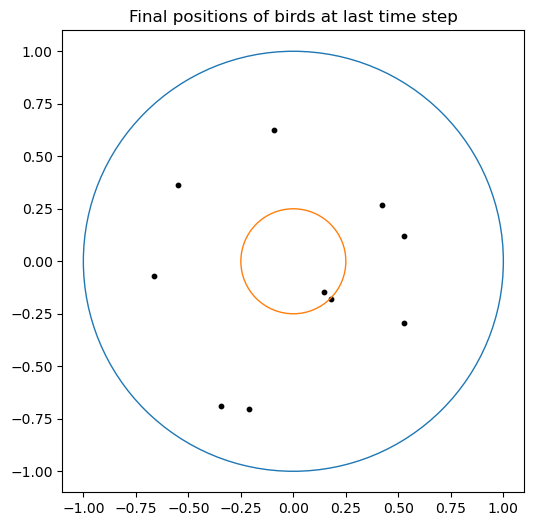

In [16]:
final_positions = np.array([bird._position for bird in birds])
plt.figure(figsize=(6,6))
plt.scatter(final_positions[:,0], final_positions[:,1], color='k', s=10)
outer_circle = plt.Circle((0, 0), 1, color='tab:blue', fill=False)
inner_circle = plt.Circle((0, 0), inner_circle_radius, color='tab:orange', fill=False)
plt.gca().add_artist(outer_circle)
plt.gca().add_artist(inner_circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.title("Final positions of birds at last time step")
plt.show()

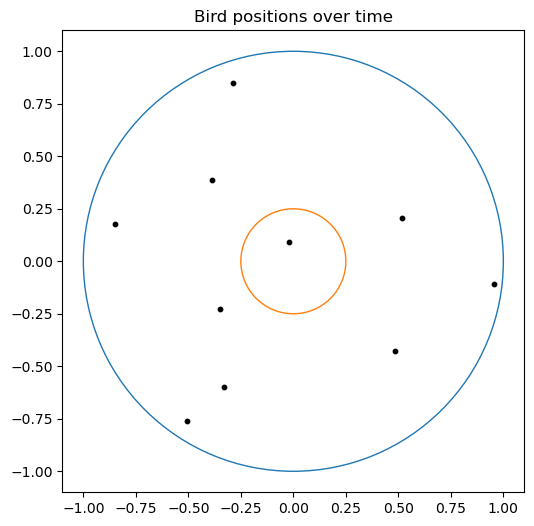

In [17]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6,6))
outer_circle = plt.Circle((0, 0), 1, color='tab:blue', fill=False)
inner_circle = plt.Circle((0, 0), inner_circle_radius, color='tab:orange', fill=False)
ax.add_artist(outer_circle)
ax.add_artist(inner_circle)
scat = ax.scatter(for_animation[0][:,0], for_animation[0][:,1], color='k', s=10)
ax.set_aspect('equal')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title("Bird positions over time")

def update(frame):
    scat.set_offsets(for_animation[frame])
    return scat,

ani = FuncAnimation(fig, update, frames=len(for_animation), interval=100, blit=True)
plt.show()
ani.save('bird_simulation.mp4', writer='ffmpeg', fps=10)